Import libraries

In [1]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from collections import defaultdict
import time
import random

import torch
print(torch.__version__)
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW, Adam
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
from transformers import set_seed

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm


2.3.0+cu121


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

Pre-trained tokenizer

In [3]:
model_variation = "gpt2"

PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

tokenizer = GPT2Tokenizer.from_pretrained(model_variation, do_lower_case=True, pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN)
# gpt2 only NL
# microsoft/CodeGPT-small-py only PL
# microsoft/CodeGPT-small-py-adaptedGPT2 both NL and PL

In [4]:
# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

In [5]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 

Read dataset

In [6]:
root_path = os.path.join('..', '..')
with open(os.path.join(root_path, 'data', 'dataset.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)

In [7]:
# Shuffle dataset
random.shuffle(data)

In [8]:
texts, labels, headlines = prepareData(data)

Explore data

Elements in dataset: 4184
2 categories found:
0
1


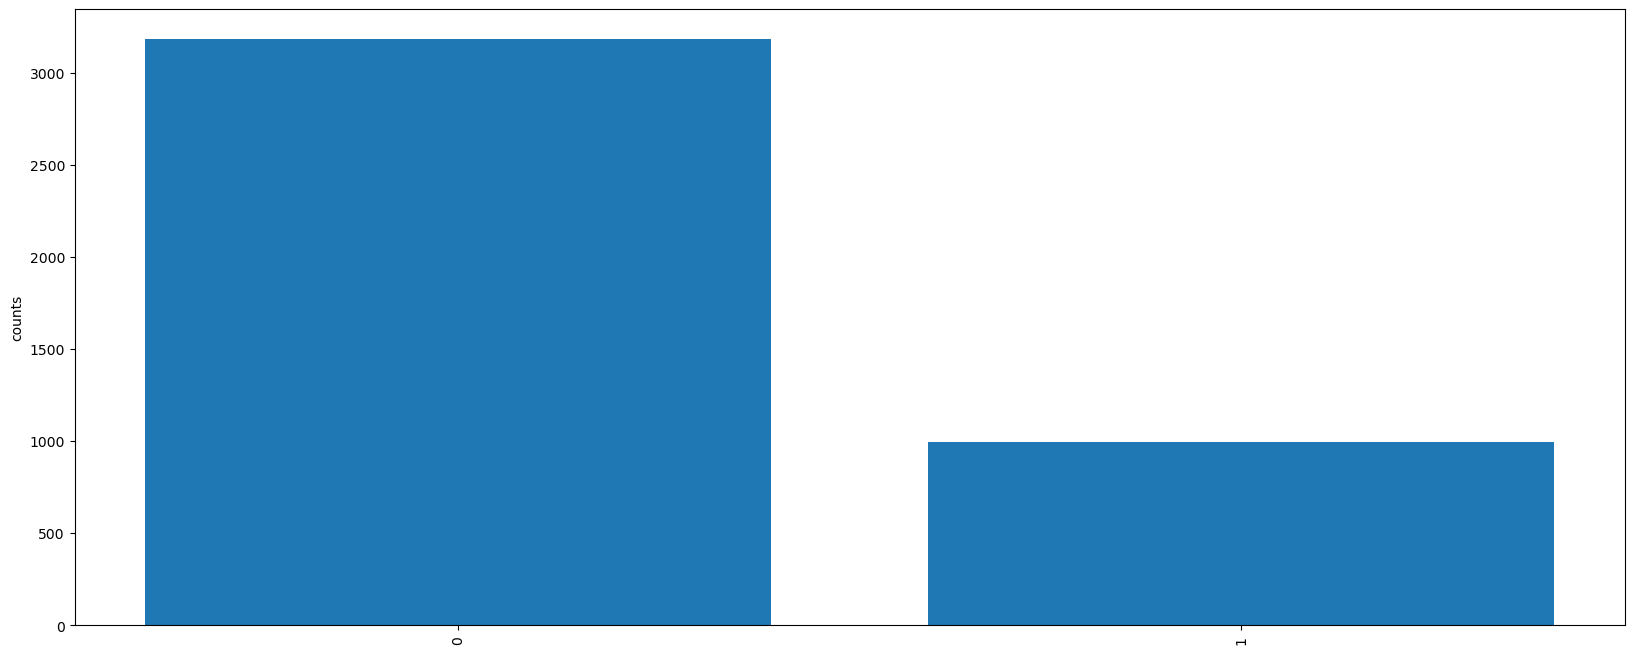

In [9]:
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [10]:
data = pd.DataFrame(({'Text': texts, 'Labels': labels}))

Split to train-val-test

In [11]:
val_ratio = 0.10

In [12]:
train_val_data, test_data = train_test_split(data, test_size=val_ratio, random_state=seed, stratify=data['Labels'])
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=seed, stratify=train_val_data['Labels'])
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

Pre-trained model

In [13]:
model = GPT2ForSequenceClassification.from_pretrained(model_variation, pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id, num_labels=n_categories)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resize model embedding to match new tokenizer

In [14]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

Compute maximum length

In [15]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    max_row = 0
    
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Convert input_ids to a PyTorch tensor
        input_ids_tensor = torch.tensor(input_ids)
        # Calculate the length of the tokenized sequence for the current sample
        length = torch.sum(input_ids_tensor != tokenizer.pad_token_id).item()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)
    
    return max_length

In [16]:
X = tokenizer(
        text=train_data['Text'].tolist(),
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors='pt',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

max_len = getMaxLen(X)

Max length of tokenized data: 512
Row with max length: 4


C:\Users\iliaskaloup\AppData\Local\Temp\ipykernel_16072\514096298.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_tensor = torch.tensor(input_ids)


Tokenization

In [17]:
X_train = tokenizer(
    text=train_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=val_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=test_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='pt',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

Hyper-parameters

In [18]:
n_epochs = 6
lr = 2e-5 #5e-05
batch_size = 6
patience = 5

In [19]:
optimizer = Adam(
    params=model.parameters(),
    lr=lr, # HF recommendation
    eps=1e-08,
    weight_decay=0.01
)

loss_fun = nn.CrossEntropyLoss()

Build Model

In [20]:
Y_train = torch.LongTensor(train_data["Labels"].tolist())
Y_val = torch.LongTensor(val_data["Labels"].tolist())
Y_test = torch.LongTensor(test_data["Labels"].tolist())
Y_train.size(), Y_val.size(), Y_test.size()

(torch.Size([3388]), torch.Size([377]), torch.Size([419]))

In [21]:
train_dataset = TensorDataset(X_train["input_ids"], X_train["attention_mask"], Y_train)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(X_val["input_ids"], X_val["attention_mask"], Y_val)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(X_test["input_ids"], X_test["attention_mask"], Y_test)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [22]:
total_steps = len(train_dataloader) * n_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, # Default value in run_glue.py 
                                            num_training_steps = total_steps)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
print(model.to(device))
print("No. of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)
No. of trainable parameters:  124443648


In [25]:
def save_checkpoint(filename, epoch, model, optimizer, train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'train_loss_per_epoch': train_loss_per_epoch,
        'val_loss_per_epoch': val_loss_per_epoch,
        'train_f1_per_epoch': train_f1_per_epoch,
        'val_f1_per_epoch': val_f1_per_epoch
        }
    torch.save(state, filename)

In [26]:
# # we do not retrain our pre-trained BERT and train only the last linear dense layer
# for param in model.bert_model.parameters():
#     param.requires_grad = False

Train model

In [28]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

# Initialize values for implementing Callbacks
## Early Stopping
best_val_f1 = -1
best_epoch = -1
no_improvement_counter = 0
## Save best - optimal checkpointing
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
save_path = os.path.join(checkpoint_dir, 'best_weights.pt')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_f1_per_epoch = []
val_f1_per_epoch = []

for epoch_num in range(n_epochs):
    print('Epoch: ', epoch_num + 1)
    
    #Training
    model.train()
    train_loss = 0
    total_preds = []
    total_labels = []
    for step_num, batch_data in enumerate(tqdm(train_dataloader, desc='Training')):
        
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                
        # clear previously calculated gradients
        model.zero_grad() # optimizer.zero_grad()
        
        # get model predictions for the current batch
        output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
        
        # compute the loss between actual and predicted values
        loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]       
        # add on to the total loss
        train_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
        # update parameters
        optimizer.step()
        scheduler.step()
        
        # Print training loss after each batch
        #print("Epoch {}/{} - Batch {}/{} - Training Loss: {:.4f}".format(epoch_num+1, n_epochs, step_num+1, len(train_dataloader), loss.item()))
        
        # model predictions are stored on GPU. So, push it to CPU
        preds = np.argmax(output.logits.cpu().detach().numpy(),axis=-1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.cpu().numpy().tolist()
        
    train_loss_per_epoch.append(train_loss / len(train_dataloader))    
    train_accuracy=accuracy_score(total_labels, total_preds)
    if n_categories > 2:
        train_precision=precision_score(total_labels, total_preds, average='macro')
        train_recall=recall_score(total_labels, total_preds, average='macro')
        train_f1=f1_score(total_labels, total_preds, average='macro')
    else:
        train_precision=precision_score(total_labels, total_preds)
        train_recall=recall_score(total_labels, total_preds)
        train_f1=f1_score(total_labels, total_preds)
        train_roc_auc=roc_auc_score(total_labels, total_preds)
    train_f2 = (5*train_precision*train_recall) / (4*train_precision+train_recall)

    #Validation
    model.eval()
    valid_loss = 0
    valid_pred = []
    actual_labels = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(val_dataloader, desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            
            output = model(input_ids = input_ids, attention_mask=att_mask) # , labels=labels
            
            preds = np.argmax(output.logits.cpu().detach().numpy(), axis=-1)
            valid_pred+=list(preds)
            actual_labels+=labels.cpu().numpy().tolist()

            loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
            valid_loss += loss.item()
        
    val_loss_per_epoch.append(valid_loss / len(val_dataloader))    
    val_accuracy=accuracy_score(actual_labels, valid_pred)
    if n_categories > 2:
        val_precision=precision_score(actual_labels, valid_pred, average='macro')
        val_recall=recall_score(actual_labels, valid_pred, average='macro')
        val_f1=f1_score(actual_labels, valid_pred, average='macro')
    else:
        val_precision=precision_score(actual_labels, valid_pred)
        val_recall=recall_score(actual_labels, valid_pred)
        val_f1=f1_score(actual_labels, valid_pred)
        val_roc_auc=roc_auc_score(actual_labels, valid_pred)
    val_f2 = (5*val_precision*val_recall) / (4*val_precision+val_recall)
    
    print("Epoch {}/{} - Train Loss: {:.4f} - Valid Loss: {:.4f}".format(epoch_num+1, n_epochs, train_loss_per_epoch[-1], val_loss_per_epoch[-1]))
    print("Epoch {}/{} - Train F1: {:.4f} - Valid F1: {:.4f}".format(epoch_num+1, n_epochs, train_f1, val_f1))
    
    train_f1_per_epoch.append(train_f1)
    val_f1_per_epoch.append(val_f1)
    
    # Implement Callbacks: Early Stopping and save best
    # Check if the validation F1 score has improved
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch_num + 1
        no_improvement_counter = 0 # Reset the counter
        
        # Save the best model checkpoint
        save_checkpoint(save_path, epoch_num+1, model.state_dict(), optimizer.state_dict(), train_loss_per_epoch, val_loss_per_epoch, train_f1_per_epoch, val_f1_per_epoch)
        print("Model saved at epoch: ", epoch_num+1)
    else:
        no_improvement_counter += 1
        
        if no_improvement_counter >= patience:
            print("No improvement for", patience, "consecutive epochs.")
            total_epochs = epoch_num + 1
            print("Early stopping after epoch No.", total_epochs)
            print("Best model after epoch No", best_epoch)
            print("Best achieved val_f1 = ", best_val_f1)
            break

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Epoch:  1


Training:   0%|          | 0/565 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/6 - Train Loss: 0.5889 - Valid Loss: 0.7693
Epoch 1/6 - Train F1: 0.3351 - Valid F1: 0.5161
Model saved at epoch:  1
Training is completed after 93185


ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

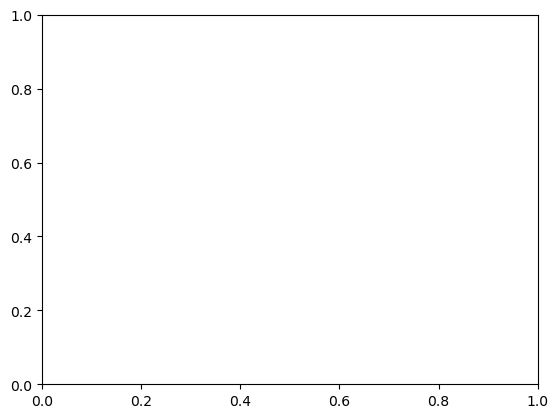

In [29]:
epochs = range(1, n_epochs + 1)
fig, ax = plt.subplots()
ax.plot(epochs, train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

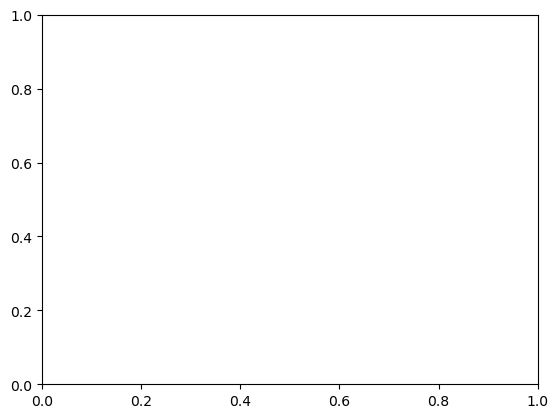

In [30]:
epochs = range(1, n_epochs + 1)
fig, ax = plt.subplots()
ax.plot(epochs, train_f1_per_epoch,label ='training F1-score')
ax.plot(epochs, val_f1_per_epoch, label = 'validation F1-score')
ax.set_title('Training and Validation F1-scores')
ax.set_xlabel('Epochs')
ax.set_ylabel('F1-score')
ax.legend()
plt.show()

Load best model from checkpoint during training with early stopping

In [31]:
checkpoint = torch.load(save_path, map_location=device)
model.load_state_dict(checkpoint["model"])
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

Make predictions on the testing set and compute evaluation metrics

In [32]:
model.eval()
test_pred = []
actual_labels = []
test_loss = 0
with torch.no_grad():
    for step_num, batch_data in enumerate(tqdm(test_dataloader, desc='Testing')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        
        output = model(input_ids = input_ids, attention_mask=att_mask) #, labels= labels

        loss = loss_fun(output.logits, labels) #loss = output.loss #output[0]
        test_loss += loss.item()
   
        preds = np.argmax(output.logits.cpu().detach().numpy(), axis=-1)
        test_pred+=list(preds)
        actual_labels+=labels.cpu().numpy().tolist()
        

Testing:   0%|          | 0/70 [00:00<?, ?it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.70      0.77       319
           1       0.40      0.64      0.49       100

    accuracy                           0.69       419
   macro avg       0.63      0.67      0.63       419
weighted avg       0.75      0.69      0.71       419

Accuracy:68.74%
Precision:40.25%
Recall:64.00%
F1 score:49.42%
F2 score:57.25%
Roc_Auc score:67.11%
TP= 64
TN= 224
FP= 95
FN= 36


<Axes: >

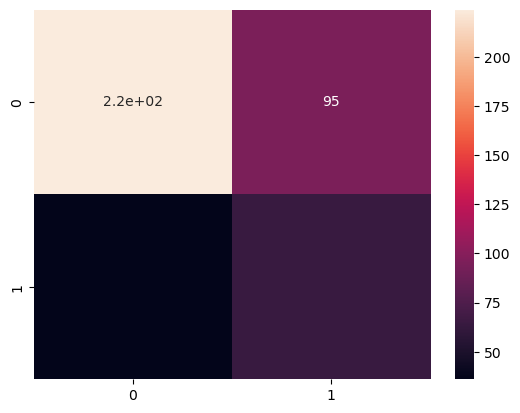

In [33]:
class_report = classification_report(actual_labels, test_pred)
print("Classification Report:\n", class_report)

total_test_loss = test_loss/len(test_dataloader) 
accuracy=accuracy_score(actual_labels, test_pred)
if n_categories > 2:
    precision=precision_score(actual_labels, test_pred, average='macro')
    recall=recall_score(actual_labels, test_pred, average='macro')
    f1=f1_score(actual_labels, test_pred, average='macro')
else:
    precision=precision_score(actual_labels, test_pred)
    recall=recall_score(actual_labels, test_pred)
    f1=f1_score(actual_labels, test_pred)
    roc_auc=roc_auc_score(actual_labels, test_pred)
f2 = (5*precision*recall) / (4*precision+recall)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))
if roc_auc:
    print("Roc_Auc score:%.2f%%"%(roc_auc*100))

conf_matrix = confusion_matrix(actual_labels, test_pred)
tn, fp, fn, tp = conf_matrix.ravel()
#acc = ((tp+tn)/(tp+tn+fp+fn))

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)
#print(conf_matrix)
sn.heatmap(conf_matrix, annot=True)